## Investments Assignment 7

#### Anita Mezzetti, Hien Le, Francesco Maizza

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import random as random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime
import statsmodels.api as sm
import wrds
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
db = wrds.Connection(wrds_username = 'maizza') 

WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


## a)

In [2]:
#import stocks
'''s = db.raw_sql("select a.permno, a.date, b.exchcd, \
                  a.ret, b.shrcd, a.shrout, a.prc \
                  from crsp.msf as a \
                  join crsp.msenames as b \
                  on a.permno = b.permno and b.namedt<=a.date \
                  and a.date<=b.nameendt \
                  where b.shrcd between (10) and (11) and \
                  a.date >='2000-01-01' and a.date<='2019-12-31'\
                  and b.exchcd between 1 and 2")'''

#s.to_csv('as7.csv')
stocks = pd.read_csv('as7.csv', index_col=0) # read the file

For each value we want one value for each month. Firstly we trasform data column in month-year(format). Then, for each stock we chack that there is only one value for each month:

In [3]:
stocks.date = pd.DatetimeIndex(stocks.date) # data format
stocks.date = stocks.date.dt.to_period('M') # data year-month
stocks = stocks.drop_duplicates(['permno','date']) # delete duplicates
stocks.sort_values(by=['permno','date'])
stocks = stocks.set_index('permno') # set permno as index

In [4]:
# We set also date as index for having a nice output
stocks_output = stocks.reset_index()
stocks_output = stocks_output.set_index(['permno','date'])
stocks_output.head()

exchcd       ret  shrout  shrcd      prc
permno  date                                             
10001.0 2009-12     2.0  0.162621  4361.0   11.0  10.3000
        2010-01     2.0 -0.018932  4361.0   11.0  10.0600
        2010-02     2.0 -0.000656  4361.0   11.0  10.0084
        2010-03     2.0  0.020643  4361.0   11.0  10.1700
        2010-04     2.0  0.124385  6070.0   11.0  11.3900

We have to delete all the stocks which have less than 240 observations. In order to do that, we can group all the stocks on permno (which identify one stock) and then count how many observations we have for each stock:

In [5]:
count = []
count = stocks.groupby('permno').count()
# now in each column we have the number of observations. We can rename one of them
count = count.rename(columns={"date":"number of observations"})
count = count[['number of observations']]
print(f"We have {count.shape[0]} different stocks. Each has a certain number of observations:")
count.head()

We have 4118 different stocks. Each has a certain number of observations:


,number of observations
permno,
10001.0,92
10028.0,140
10042.0,98
10051.0,233
10066.0,28


Now we delete  stocks with less than 240 observations:

Note: This is equal to have only stocks with preciselt 240 observations. Because we want that they are traded EVERY mounth for 20 years: 

20 years*12 mounths = 240 observation. 

In [6]:
decision = count[['number of observations']]!=240 # delete if true
decision = decision.dropna() # drop NaN
decision.head()

,number of observations
permno,
10001.0,True
10028.0,True
10042.0,True
10051.0,True
10066.0,True


In [7]:
decision_true = decision[decision['number of observations']] # keep only true
print(f"We delete {decision_true.shape[0]} stocks.")
stocks_del = stocks.drop(index=decision_true.index) # drop the stocks that have < 240 observations
stocks_del.head()

We delete 3479 stocks.


,date,exchcd,ret,shrout,shrcd,prc
permno,,,,,,
10145.0,2000-01,1.0,-0.167931,789233.0,11.0,48.000000
10145.0,2001-07,1.0,0.059088,809281.0,11.0,36.869999
10145.0,2001-08,1.0,0.015663,811616.0,11.0,37.259998
10145.0,2001-09,1.0,-0.291465,811616.0,11.0,26.400000
10145.0,2001-10,1.0,0.119318,811619.0,11.0,29.549999


We should have 639 stocks:

In [8]:
# we have deleted decision_true
# we are left with the rest of decision
num_deleted = int(decision_true.count())
num_left = int(decision.count()-decision_true.count())
print(f"We have deleted {num_deleted} and we are left with {num_left} stocks")

We have deleted 3479 and we are left with 639 stocks


Delete 3 NaN stocks: fisrt we delete null returns. This operation doesn not remove all the stock obersavations, but only the null ones. In order to cancel all the observations of stocks with NaN values, we re-check that stocks actually have 240 obersations.

In [9]:
is_na = stocks_del.ret.isna()
num_before = len(stocks_del.index)
stocks_del = stocks_del[~is_na] # delete null returns
num_then = len(stocks_del.index)
if any(is_na) == True:
    print(f"{num_before-num_then} returns are NaN")

3 returns are NaN


We are to cancel not only the row with nan return, but allthe stock, which now it has not 240 observations.

In [10]:
count = []
count = stocks_del.groupby('permno').count()

# now in each column we have the number of observations. 
#We can rename one of them
count = count.rename(columns={"date":"number of observations"})
count = count[['number of observations']]

decision = count[['number of observations']]!=240 # delete if true
#decision = decision.dropna() # drop NaN

In [11]:
decision_true = decision[decision['number of observations']] # keep only true
print(f"We delete {decision_true.shape[0]} stocks.")
stocks_del = stocks_del.drop(index=decision_true.index) # drop the stocks that have < 240 observations
stocks_del.head()

We delete 3 stocks.


,date,exchcd,ret,shrout,shrcd,prc
permno,,,,,,
10145.0,2000-01,1.0,-0.167931,789233.0,11.0,48.000000
10145.0,2001-07,1.0,0.059088,809281.0,11.0,36.869999
10145.0,2001-08,1.0,0.015663,811616.0,11.0,37.259998
10145.0,2001-09,1.0,-0.291465,811616.0,11.0,26.400000
10145.0,2001-10,1.0,0.119318,811619.0,11.0,29.549999


In [12]:
# we have deleted decision_true
# we are left with the rest of decision
num_deleted = int(decision_true.count())
num_left = int(decision.count()-decision_true.count())
print(f"We have deleted {num_deleted} and we are left with {num_left} stocks")

We have deleted 3 and we are left with 636 stocks


In [13]:
is_na = stocks_del.ret.isna()
num_before = len(stocks_del.index)
stocks_del = stocks_del[~is_na] # delete null returns
num_then = len(stocks_del.index)
if any(is_na) == True:
    print(f"{num_before-num_then} returns are NaN")
else:
    print("Now we do not have NaN returns")

Now we do not have NaN returns


Now, we can add the risk free rate and market returns. 

In [14]:
# import risk free rate
risk_free = db.raw_sql("select mcaldt as date, tmytm as rf from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='2000-01-01' and mcaldt<='2019-12-31'")
risk_free_m = np.exp(np.divide(risk_free.rf, 1200)) -1
rf = pd.DataFrame([risk_free.date, risk_free_m], index=['date', 'rf']).T

# import market
market = db.raw_sql("select date, vwretd from crsp.msi where date>='2000-01-01' and date<='2019-12-31'")
market_m = pd.DataFrame([market.date, market.vwretd.values], index=['date', 'mkt_ret']).T
rm = market_m.set_index('date')

In [15]:
rf.date = pd.DatetimeIndex(rf.date) # data format
rf.date = rf.date.dt.to_period('M') # data year-month
rf = rf.set_index('date')
rf.head()

,rf
date,
2000-01,0.00449835
2000-02,0.00443834
2000-03,0.00489188
2000-04,0.00440126
2000-05,0.00390314


In [16]:
rm.index = pd.DatetimeIndex(rm.index) # data format
rm.index = rm.index.to_period('M') # data year-month
rm.head()

,mkt_ret
date,
2000-01,-0.0396243
2000-02,0.0317784
2000-03,0.0535007
2000-04,-0.059527
2000-05,-0.0388696


In [17]:
save = stocks_del

In [18]:
stocks_del = save

## b)

Caculate market capitalization, making sure that we have absolute values of share prices:

In [19]:
stocks_del['prc'] = stocks_del['prc'].abs() # absolute value of the share price
stocks_del['mrk_cap'] = stocks_del['prc'] * stocks_del['shrout']
stocks_del.head()

,date,exchcd,ret,shrout,shrcd,prc,mrk_cap
permno,,,,,,,
10145.0,2000-01,1.0,-0.167931,789233.0,11.0,48.000000,3.788318e+07
10145.0,2001-07,1.0,0.059088,809281.0,11.0,36.869999,2.983819e+07
10145.0,2001-08,1.0,0.015663,811616.0,11.0,37.259998,3.024081e+07
10145.0,2001-09,1.0,-0.291465,811616.0,11.0,26.400000,2.142666e+07
10145.0,2001-10,1.0,0.119318,811619.0,11.0,29.549999,2.398334e+07


We calculate the beta

In [20]:
# list of right permnos (no duplicates):
list_permno = list(stocks_del.loc[~stocks_del.index.duplicated(keep='first')].index)

market_beta = [] # market beta 

#cycle for each stock (639 elemets)
for i in list_permno: # (list_permno): 
    current_stock = stocks_del.loc[i] # long 240 because we have 240 observations for each stock
    ret_cur_stock = current_stock.ret.values.astype(float) # 240 returns for each stock
    rm_cur_stock = rm.loc[current_stock.date].mkt_ret.astype(float)
    covariance = np.cov(ret_cur_stock, rm_cur_stock) # Cov(R,Rm)
    var_market = covariance[1,1] # var(Rm)
    market_beta.append(covariance[0,1]/var_market) # add new beta
    
# Create a DataFrame where for each stock we have its beta
data = pd.DataFrame(market_beta, columns={'beta'}, index=list_permno) # for each stock we have its beta
data = data.sort_index()

print(type(stocks_del))

# We add to the stocks dataframe our beta, creating a new column:
stocks_del = stocks_del.merge(data, left_index=True, right_index=True)
#stocks_del = stocks_del.drop(stocks_del.loc[stocks_del.beta.isnull()].index)#.set_index(['permno','date']) # re-index
stocks_del.head()

<class 'pandas.core.frame.DataFrame'>


,date,exchcd,ret,shrout,shrcd,prc,mrk_cap,beta
10145.0,2000-01,1.0,-0.167931,789233.0,11.0,48.000000,3.788318e+07,1.20019
10145.0,2001-07,1.0,0.059088,809281.0,11.0,36.869999,2.983819e+07,1.20019
10145.0,2001-08,1.0,0.015663,811616.0,11.0,37.259998,3.024081e+07,1.20019
10145.0,2001-09,1.0,-0.291465,811616.0,11.0,26.400000,2.142666e+07,1.20019
10145.0,2001-10,1.0,0.119318,811619.0,11.0,29.549999,2.398334e+07,1.20019


Form 10 groups of stocks based on the market capitalization of 31 dec 2019, with first decile being group 1 on so on:

In [21]:
# list of right permnos (no duplicates):
stocks_del = stocks_del.sort_index(axis = 0) 
list_permno = list(stocks_del.loc[~stocks_del.index.duplicated(keep='first')].index)

# consider market capitalization on dec 2019
stocks_dec2019 = stocks_del[stocks_del.date.astype(str).values=='2019-12']
stocks_dec2019 = stocks_dec2019.sort_index(axis = 0) 
stocks_dec2019.head()

,date,exchcd,ret,shrout,shrcd,prc,mrk_cap,beta
10145.0,2019-12,1.0,-0.008681,714533.0,11.0,177.000000,1.264723e+08,1.200190
10294.0,2019-12,1.0,0.006728,1535.0,11.0,20.200001,3.100700e+04,0.758752
10308.0,2019-12,2.0,0.054755,14940.0,11.0,91.500000,1.367010e+06,0.443625
10516.0,2019-12,1.0,0.079665,556686.0,11.0,46.349998,2.580240e+07,0.497710
10517.0,2019-12,1.0,-0.021404,67152.0,11.0,57.110001,3.835051e+06,0.642811


In [22]:
# creation on 10 groups
a = pd.qcut(stocks_dec2019.mrk_cap,10)
decile = pd.DataFrame(pd.qcut(stocks_dec2019.mrk_cap,10))
decile = decile.rename(columns={"mrk_cap":"decile"})
decile.head()

,decile
10145.0,"(54953204.591, 437225989.856]"
10294.0,"(2640.959, 221410.898]"
10308.0,"(848916.265, 1570788.675]"
10516.0,"(23590062.289, 54953204.591]"
10517.0,"(2728756.376, 4603126.817]"


In [23]:
inters = list(dict.fromkeys(a))
#inters.sort()
inters = [x for x in inters if str(x) != 'nan'] # drop NoN. We always put a control just to be sure
print(f"We have {len(inters)} groups of stcoks.")

We have 10 groups of stcoks.


In [24]:
# for each portfolio we have the decile to which it belongs
group_decile = decile.sort_values(by="decile") # sort for decile
group_decile.reset_index(inplace=True)
group_decile = group_decile.dropna() # drop NaN
group_decile = group_decile.groupby("decile")
group_decile.head()

,index,decile
0,74908.0,"(2640.959, 221410.898]"
1,18075.0,"(2640.959, 221410.898]"
2,59185.0,"(2640.959, 221410.898]"
3,79702.0,"(2640.959, 221410.898]"
4,29058.0,"(2640.959, 221410.898]"
64,85440.0,"(221410.898, 848916.265]"
65,65365.0,"(221410.898, 848916.265]"
66,34673.0,"(221410.898, 848916.265]"
67,45728.0,"(221410.898, 848916.265]"
68,41217.0,"(221410.898, 848916.265]"


**EQUALLY WEIGHTED RETURNS**

In [25]:
month_list = stocks_del.date.drop_duplicates(keep='first').values
stocks_del = stocks_del.sort_values('date') #sort for date
ew_ret = []

for month in month_list[0:100]: # for each month 
    stocks_del_month = stocks_del[stocks_del.date.values==month]
    
    ew_ret_month = [] # returns of equally weighted portfolios
    for i in inters: # each decile
        stock_interval = group_decile.get_group(i)["index"]
        temp = stocks_del_month.loc[stock_interval] 
        #group_date = temp.groupby('date').mean()
        ew_ret_month.append(temp.ret.mean()) # equal weighted => mean
        
    ew_ret.append(ew_ret_month)
    
for month in month_list[100:240]: # for each month 
    stocks_del_month = stocks_del[stocks_del.date.values==month]
    
    ew_ret_month = [] # returns of equally weighted portfolios
    for i in inters: # each decile
        stock_interval = group_decile.get_group(i)["index"]
        temp = stocks_del_month.loc[stock_interval] 
        #group_date = temp.groupby('date').mean()
        ew_ret_month.append(temp.ret.mean()) # equal weighted => mean
        
    ew_ret.append(ew_ret_month)

In [26]:
'''ew_ret = []

def alphaa(x):
        ew_ret_month = [] # returns of equally weighted portfolios
        for i in inters: # each decile
            stock_interval = group_decile.get_group(i)["index"]
            temp = x.loc[stock_interval] 
            ew_ret_month.append(temp.ret.mean()) # equal weighted => mean
        ew_ret.append(ew_ret_month)
        return ew_ret

ew_ret = stocks_del.groupby('date').apply( lambda x: alphaa(x))
ew_ret'''

'ew_ret = []\n\ndef alphaa(x):\n        ew_ret_month = [] # returns of equally weighted portfolios\n        for i in inters: # each decile\n            stock_interval = group_decile.get_group(i)["index"]\n            temp = x.loc[stock_interval] \n            ew_ret_month.append(temp.ret.mean()) # equal weighted => mean\n        ew_ret.append(ew_ret_month)\n        return ew_ret\n\new_ret = stocks_del.groupby(\'date\').apply( lambda x: alphaa(x))\new_ret'

**EQUALLY: AVERAGE EXCESS RETURN**

In [27]:
exc_ret_ew = []
for i in range(len(month_list)): # for each month
        risk_free = rf.rf[i] # rf of that month
        risk_free_list = [risk_free]*10 
        exc_ret_ew.append(np.asarray(ew_ret[i])-risk_free)

returns_eqw=pd.DataFrame(exc_ret_ew).mean()
returns_eqw.index += 1 
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(returns_eqw)


1     0.008919
2     0.008926
3     0.011704
4     0.011035
5     0.011328
6     0.011896
7     0.010245
8     0.010758
9     0.011470
10    0.012094
dtype: float64


**REGRESSION EQUALLY WEIGHTED**

In [28]:
# trasform exc_ret_ew in a matrix to work more easily
exc_ret_ew = np.array(exc_ret_ew).T #trasponse in order to have one all month returns for each row (10 rows)

In [29]:
# market risk premium: one value for each month
risk_premium = rm.mkt_ret.values-rf.rf.values 

In [30]:
alpha_ew = []
beta_ew = []

print("EQUALLY WEIGHTED")
for i in range(10):
    Y = np.array(exc_ret_ew[i], dtype=float)
    X = np.array(risk_premium, dtype=float)
    X = sm.add_constant(X)
    reg=sm.OLS(Y,X).fit()
    print(reg.summary())
    model_parameters = sm.OLS(Y,X).fit().params
    alpha_ew.append(model_parameters[0])
    beta_ew.append(model_parameters[1])
    print (f"For the portfolio number {i+1}: alpha = {model_parameters[0]} and beta = {model_parameters[1]} ")
   

EQUALLY WEIGHTED
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.806
Date:                Sun, 05 Apr 2020   Prob (F-statistic):             0.0293
Time:                        21:51:00   Log-Likelihood:                 444.95
No. Observations:                 240   AIC:                            -885.9
Df Residuals:                     238   BIC:                            -878.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.002   

**VALUE WEIGHTED**

In [31]:
# LAGGED market capitalization:
stocks_del['lagged_mrk_cap'] =  stocks_del.groupby(stocks_del.index)['mrk_cap'].shift(1) # lagged market cap
print("We can see that lagged mark_cap for each stock is NaN for the first month:")
stocks_del.head()

We can see that lagged mark_cap for each stock is NaN for the first month:


,date,exchcd,ret,shrout,shrcd,prc,mrk_cap,beta,lagged_mrk_cap
10145.0,2000-01,1.0,-0.167931,789233.0,11.0,48.0000,3.788318e+07,1.200190,NaN
82171.0,2000-01,2.0,-0.071111,2731.0,11.0,7.1250,1.945838e+04,0.457695,NaN
76963.0,2000-01,2.0,-0.322034,28944.0,11.0,2.5000,7.236000e+04,1.575371,NaN
77117.0,2000-01,1.0,-0.109833,22979.0,11.0,13.3125,3.059079e+05,1.881616,NaN
48725.0,2000-01,1.0,-0.078684,248568.0,11.0,40.2500,1.000486e+07,0.821145,NaN


In [32]:
stocks_del.lagged_mrk_cap = stocks_del.lagged_mrk_cap.fillna(0) # fill nan with zero (zero weight)
month_list = stocks_del.date.drop_duplicates(keep='first').values
stocks_del = stocks_del.sort_values('date') #sort for date
vw_ret = []

for month in month_list: # for each month 
    stocks_del_month = stocks_del[stocks_del.date.values==month]
    
    vw_ret_month = [] # returns of equally weighted portfolios
    for i in inters: # each decile
        
        stock_interval = group_decile.get_group(i)["index"]
        temp = stocks_del_month.loc[stock_interval] # stocks for that month for that decile 
        
        # calculate weights
        weight_sum = temp.lagged_mrk_cap.sum() # sum of mark_cap
        weights = temp.lagged_mrk_cap / weight_sum #weights
        
        # calulate value weighted ret
        ret = (temp.ret*weights).sum()
        
        vw_ret_month.append(vw_ret)
        

    vw_ret.append(ew_ret_month)

In [33]:
vw_ret[0:2]

[[0.03471445012473852,
  -0.003568102762074001,
  0.063866024888638,
  0.03402904127280982,
  0.06180031363674924,
  0.05213305808320001,
  0.04345878504682332,
  0.030418684393225676,
  0.04641918614652241,
  0.041942143557077656],
 [0.03471445012473852,
  -0.003568102762074001,
  0.063866024888638,
  0.03402904127280982,
  0.06180031363674924,
  0.05213305808320001,
  0.04345878504682332,
  0.030418684393225676,
  0.04641918614652241,
  0.041942143557077656]]

**VALUE: AVERAGE EXCESS RETURN**

In [34]:
exc_ret_vw = []

for i in range(len(month_list)): # for each month
    risk_free = rf.rf[i] # rf of that month
    risk_free_list = [risk_free]*10 
    exc_ret_vw.append(np.asarray(vw_ret[i])-risk_free)

returns_vw=pd.DataFrame(exc_ret_vw).mean()
returns_vw.index += 1 
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(returns_vw)

1     0.033399
2    -0.004883
3     0.062551
4     0.032714
5     0.060485
6     0.050818
7     0.042143
8     0.029103
9     0.045104
10    0.040627
dtype: float64


In [35]:
# trasform vw_ret in a matrix to work more easily
exc_ret_vw = np.array(exc_ret_vw).T #trasponse in order to have one all month returns for each row (10 rows)

**REGRESSION VALUE WEIGHTED**

In [36]:
alpha_vw = []
beta_vw = []

print("VALUE WEIGHTED")
for i in range(10):
    Y= np.array(exc_ret_vw[i], dtype=float)
    X= np.array(risk_premium, dtype=float)
    X = sm.add_constant(X)
    reg=sm.OLS(Y,X).fit()
    print(reg.summary())
    model_parameters = sm.OLS(Y,X).fit().params
    alpha_vw.append(model_parameters[0])
    beta_vw.append(model_parameters[1])
    print (f"For the portfolio number {i+1}: alpha = {model_parameters[0]} and beta = {model_parameters[1]}")
 

VALUE WEIGHTED
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.265
Date:                Sun, 05 Apr 2020   Prob (F-statistic):             0.0720
Time:                        21:53:07   Log-Likelihood:                 1225.4
No. Observations:                 240   AIC:                            -2447.
Df Residuals:                     238   BIC:                            -2440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0334   9.56e-05    3

**PLOT**

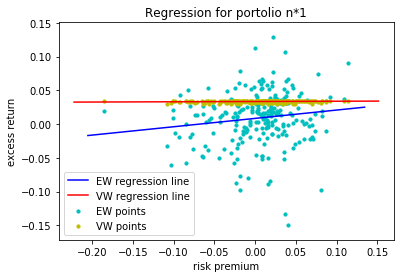

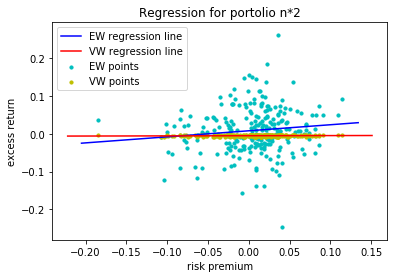

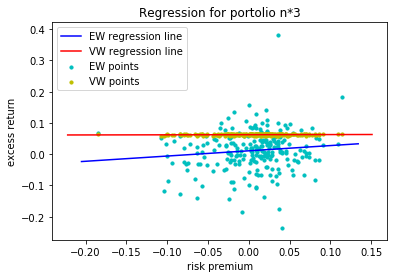

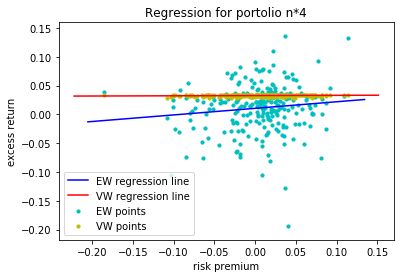

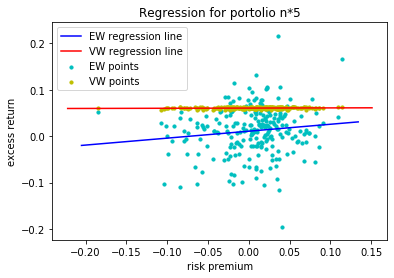

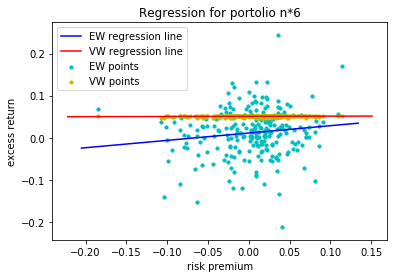

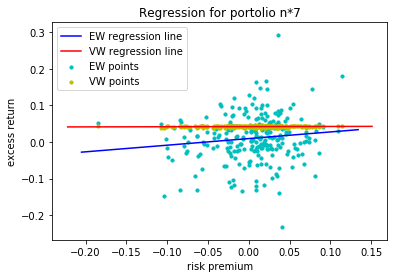

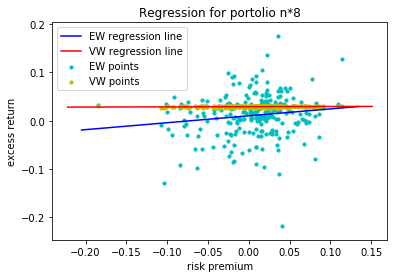

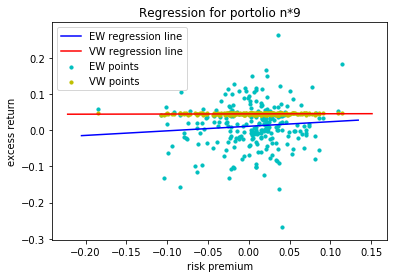

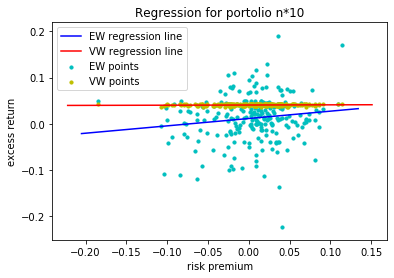

In [37]:
for i in range(10):
    
    # equally
    plt.scatter(risk_premium, exc_ret_ew[i], s=10, c='c')
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    intercept= alpha_ew[i]
    slope = beta_ew[i]
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'b')
    plt.title('Regression for portolio n*'+ str(i+1))
    
    #value
    plt.scatter(risk_premium, exc_ret_vw[i], s=10, c='y')
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    intercept= alpha_vw[i]
    slope = beta_vw[i]
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'r')
    
    plt.legend([ 'EW regression line', 'VW regression line', 'EW points','VW points'])
    plt.title('Regression for portolio n*'+ str(i+1))
    plt.xlabel('risk premium')
    plt.ylabel('excess return')
    plt.show()

## C)

Based on the results in part b), how is market capitalization related to average excess returns? Can the capm explain the behavior of the stocks? Consider equally weighted and value-weighted returns separately.

## D)

In [193]:
stocks_del_lagged = stocks_del # ora lo duplichi poi sostituisci la colonna mark cap con la sua laggata  
#stocks_del_lagged['mrk_cap'] =  stocks_del.groupby(stocks_del.index)['mrk_cap'].shift(1) # lagged market cap
stocks_del_lagged=stocks_del_lagged.fillna(0)
stocks_del_lagged = stocks_del_lagged[stocks_del_lagged.date != '2000-01']
b = stocks_del_lagged.groupby('date').apply(lambda x : pd.qcut(x.lagged_mrk_cap,10))
decile_each_month=b.to_frame()

In [194]:


decile_each_month
#decile_each_month.rename(columns={"lagged_mrk_cap":"decile"})
#decile_each_month.rename(columns = {decile_each_month.columns[1]: 'decile'}, inplace = True)
type(decile_each_month)
decile_each_month

lagged_mrk_cap
date                                          
2000-02 65285.0        (91208.938, 190725.312]
        40539.0       (2910611.938, 6557162.5]
        63781.0       (190725.312, 335063.125]
        67360.0        (91208.938, 190725.312]
        86593.0          (6120.811, 91208.938]
...                                        ...
2019-12 10517.0     (2646146.284, 4387579.809]
        10516.0   (22628724.057, 53360457.782]
        10308.0      (815434.385, 1456002.841]
        10933.0   (12419052.318, 22628724.057]
        92655.0  (53360457.782, 413263246.371]

[152004 rows x 1 columns]

In [ ]:
for date in decile_each_month.index.get_level_values('date').unique():
    print(decile_each_month.loc[date])

equally weighted returns

In [185]:
inters = list(dict.fromkeys(b))
#inters.sort()
inters = [x for x in inters if str(x) != 'nan'] # drop NoN. We always put a control just to be sure
print(f"We have {len(inters)} groups of stocks.") 
type(decile_each_month)

We have 2390 groups of stocks.


pandas.core.frame.DataFrame

In [195]:
decile_each_month = decile_each_month.sort_values(by="lagged_mrk_cap") # sort for decile
decile_each_month.reset_index(inplace=True)
decile_each_month = decile_each_month.groupby("lagged_mrk_cap")
decile_each_month.head()

,date,level_1,lagged_mrk_cap
0,2016-03,49138.0,"(1265.549, 169773.255]"
1,2016-03,82768.0,"(1265.549, 169773.255]"
2,2016-03,54244.0,"(1265.549, 169773.255]"
3,2016-03,85939.0,"(1265.549, 169773.255]"
4,2016-03,92583.0,"(1265.549, 169773.255]"
...,...,...,...
151940,2019-12,14541.0,"(53360457.782, 413263246.371]"
151941,2019-12,10145.0,"(53360457.782, 413263246.371]"
151942,2019-12,17005.0,"(53360457.782, 413263246.371]"
151943,2019-12,11308.0,"(53360457.782, 413263246.371]"


In [196]:
type(decile_each_month)
#months_list = decile_each_month.date.drop_duplicates(keep='first').values

pandas.core.groupby.generic.DataFrameGroupBy

In [189]:
months_list = decile_each_month.date.drop_duplicates(keep='first').values
decile_each_month = decile_each_month.sort_values('date') 
ew_retp = []

for month in month_list[0:100]: # for each month 
    portfolio_del_month = portfolio_del_month[portfolio_del_month.date.values==month]
    
    ew_ret_month = [] # returns of equally weighted portfolios
    for i in inters: # each decile
        port_interval = decile_each_month.get_group(i)["index"]
        temp = portfolio_del_month.loc[port_interval] 
        #group_date = temp.groupby('date').mean()
        ew_retp_month.append(temp.ret.mean()) # equal weighted => mean
        
    ew_retP.append(ew_retp_month)
    
#for month in month_list[100:240]: # for each month 
#stocks_del_month = stocks_del[stocks_del.date.values==month]
    #ew_ret_month = [] # returns of equally weighted portfolios
    ####for i in inters: # each decile
      ###  stock_interval = group_decile.get_group(i)["index"]
       ###group_date = temp.groupby('date').mean()
        ##ew_ret_month.append(temp.ret.mean()) # equal weighted => mean
        
    #ew_ret.append(ew_ret_month)


AttributeError: Cannot access callable attribute 'drop_duplicates' of 'SeriesGroupBy' objects, try using the 'apply' method